# Multi-Agent System for Instagram Content Creation
Project Video Link: https://drive.google.com/file/d/1zokdSuslT_UlJbCCcRj4fEuuDS0xqOvz/view?usp=sharing

## 1. Install Dependencies

In [ ]:
# Install required packages
!pip install -q crewai crewai_tools tavily-python langchain-openai langchain_community requests Pillow python-dotenv

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.9/642.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.0/765.0 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.9/160.9 kB 10.3 MB/s e

## 2. API Configuration

In [ ]:
import os

# Set environment variables
os.environ["GITHUB_TOKEN"] = "GITHUB_TOKEN"
os.environ["TAVILY_API_KEY"] = "TAVILY_API_KEY"
os. environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"
os.environ["OPENAI_API_BASE"] = "https://models.github.ai/inference"

print("API Keys configured successfully!")

API Keys configured successfully!


## 3. Import Libraries & Setup

In [ ]:
from crewai import Agent, Task, Crew, Process, LLM
from crewai.tools import tool
from tavily import TavilyClient
import requests
from PIL import Image
from io import BytesIO
from IPython.display import Image as IPImage, display

# Initialize Tavily
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

# Initialize LLM with GitHub Models
llm = LLM(
    model="gpt-4.1-mini",
    api_key=os.environ["GITHUB_TOKEN"],
    base_url="https://models.github.ai/inference"
)

print("Libraries imported and LLM configured!")

Libraries imported and LLM configured!


## 4. Define Tools

In [ ]:
@tool("Tavily Web Research Tool")
def tavily_search(query: str) -> str:
    """
    Advanced web research using Tavily AI.
    Returns comprehensive results with AI-generated summary.
    """
    try:
        response = tavily_client.search(
            query=query,
            search_depth="advanced",
            max_results=5,
            include_answer=True
        )

        output = []

        # Add AI summary
        if response.get('answer'):
            output.append(f"**AI Summary:**\n{response['answer']}\n")

        # Add detailed sources
        output.append("**Detailed Sources:**\n")
        for i, result in enumerate(response.get('results', []), 1):
            output. append(
                f"**{i}. {result['title']}**\n"
                f"{result['content']}\n"
                f"Source: {result['url']}\n"
            )

        return "\n".join(output)

    except Exception as e:
        return f"Error during search: {str(e)}"

print("Tavily Research Tool created!")

Tavily Research Tool created!


In [ ]:
def generate_image(prompt: str, filename: str) -> str:
    """
    Generate image using Pollinations AI
    """
    import urllib.parse

    # Encode prompt for URL
    encoded_prompt = urllib. parse.quote(prompt)

    # Pollinations API endpoint
    url = f"https://image.pollinations.ai/prompt/{encoded_prompt}?width=1024&height=1024&nologo=true&model=flux"

    try:
        print(f"Generating with Pollinations AI...")
        response = requests.get(url, timeout=60)

        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            img.save(filename)
            return f"Image saved as {filename}"
        else:
            return f"Error {response.status_code}"

    except Exception as e:
        return f"Error: {str(e)}"

print("Image Generation Tool created!")

Image Generation Tool created!


## 5. Create Agents

In [ ]:
# Agent 1: Research Agent
research_agent = Agent(
    role='Senior Social Media Research Specialist',
    goal='Conduct comprehensive research using Tavily AI to find viral trends, statistics, and engaging insights for Instagram content',
    backstory="""You are an expert social media researcher with 10+ years of experience.
    You specialize in identifying viral content angles, trending topics, and data-driven
    insights that resonate with Instagram audiences.  You use advanced AI search tools
    to uncover the most engaging information.""",
    tools=[tavily_search],
    verbose=True,
    llm=llm
)

# Agent 2: Content Writer Agent
writer_agent = Agent(
    role='Expert Instagram Content Creator',
    goal='Write scroll-stopping Instagram captions that maximize engagement, saves, and shares',
    backstory="""You are a professional Instagram copywriter who has created viral
    content for accounts with millions of followers. You know exactly how to write
    hooks that stop the scroll, structure captions for mobile readability, and use
    strategic hashtags and CTAs to drive engagement.""",
    verbose=True,
    llm=llm
)

# Anent 3: Content Reviewer Agent
reviewer_agent = Agent(
    role='Senior Content Editor & Quality Assurance Specialist',
    goal='Review and optimize Instagram content for grammar, tone, clarity, and maximum engagement potential',
    backstory="""You are a meticulous content editor who has worked with top Instagram
    influencers and Fortune 500 brands. You ensure every caption is grammatically
    perfect, tonally consistent, and optimized for maximum engagement. Your edits
    consistently improve performance metrics.""",
    verbose=True,
    llm=llm
)

# Agent 4: Image Prompt Generator Agent
image_agent = Agent(
    role='Master AI Image Prompt Engineer',
    goal='Create highly detailed, optimized prompts that generate stunning Instagram-worthy visuals using Stable Diffusion',
    backstory="""You are a renowned AI prompt engineer specializing in text-to-image
    generation for social media. You have mastered Stable Diffusion and know exactly
    how to craft prompts that produce eye-catching, professional-quality images with
    perfect composition, lighting, and Instagram aesthetics.""",
    verbose=True,
    llm=llm
)

print("All 4 agents created successfully!")
print("1. Research Agent (Tavily)")
print("2. Writer Agent")
print("3. Reviewer Agent")
print("4. Image Prompt Agent")

All 4 agents created successfully!
1. Research Agent (Tavily)
2. Writer Agent
3. Reviewer Agent
4. Image Prompt Agent


## 6. Create Tasks

In [ ]:
def create_tasks(topic: str):
    """
    Creates tasks for all 4 agents based on the topic.
    """

    # Task 1: Research
    task1 = Task(
        description=f"""
        Research the topic: '{topic}'

        Use Tavily search tool to find:
        1. Latest trends and developments (2024-2025)
        2.  Surprising statistics and data points
        3. Viral angles and engaging insights
        4. Expert opinions and quotes
        5. Common questions people are asking

        Focus on information that would resonate with Instagram audiences
        and drive high engagement.
        """,
        agent=research_agent,
        expected_output="Comprehensive research report with 5-7 key insights, statistics, viral angles, and credible sources."
    )

    # Task 2: Write Captions
    task2 = Task(
        description=f"""
        Based on the research, write TWO Instagram caption versions for '{topic}':

        **SHORT VERSION (10-15 words):**
        - Powerful hook (first line)
        - 2-3 key insights with strategic emojis
        - Strong call-to-action
        - 5-7 relevant hashtags

        **LONG VERSION (20-30 words):**
        - Compelling story-driven hook
        - Detailed insights from research
        - Strategic emoji placement
        - Engaging call-to-action
        - 7-12 strategic hashtags

        Both versions must be:
        - Conversational and authentic
        - Value-driven
        - Scroll-stopping
        - Designed to maximize engagement
        """,
        agent=writer_agent,
        expected_output="Two complete Instagram captions (short and long versions) with hashtags, emojis, and CTAs clearly labeled.",
        context=[task1]
    )

    # Task 3: Review & Optimize
    task3 = Task(
        description=f"""
        Review and optimize both Instagram caption versions.

        Check for:
        1. Grammar and spelling (zero errors required)
        2. Hook strength (rate 1-10 and improve if needed)
        3. Mobile readability (line breaks, spacing, emojis)
        4. Hashtag relevance and strategy
        5. CTA effectiveness
        6. Overall engagement potential

        Provide:
        - Polished, final versions of both captions and hashtags
        """,
        agent=reviewer_agent,
        expected_output="Two publication-ready Instagram captions with hashtags.",
        context=[task2]
    )

    # Task 4: Generate Image Prompts
    task4 = Task(
        description=f"""
        Create 3 detailed Stable Diffusion image prompts for '{topic}':

        **PROMPT 1 - PHOTOREALISTIC:**
        Professional photography style, 8k quality, realistic lighting, magazine-worthy

        **PROMPT 2 - CREATIVE/ARTISTIC:**
        Bold artistic style, vibrant colors, trending on artstation, eye-catching

        **PROMPT 3 - MINIMALIST:**
        Clean design, negative space, modern aesthetic, Instagram-ready

        Each prompt must include (60-100 words):
        - Subject and composition details
        - Lighting and color palette
        - Style and mood descriptors
        - Technical quality tags

        Optimize for Stable Diffusion XL and Instagram aesthetics.
        """,
        agent=image_agent,
        expected_output="Three complete, clearly labeled image generation prompts optimized for Stable Diffusion, ready to use immediately.",
        context=[task1, task3]
    )

    return [task1, task2, task3, task4]

print("Task creation function ready!")

Task creation function ready!


## 7. Run Content Creation System

In [ ]:
def run_content_creator(topic: str):
    """
    Executes the complete Instagram content creation workflow.
    """
    print(f"\n{"─"*200}")
    print(f"Instagram Content Creation Started...")
    print(f"{"─"*200}")
    print(f"\nTopic: {topic}\n")

    # Create tasks
    tasks = create_tasks(topic)

    # Create crew
    crew = Crew(
        agents=[research_agent, writer_agent, reviewer_agent, image_agent],
        tasks=tasks,
        process=Process.sequential,
        verbose=True
    )

    # Execute
    result = crew.kickoff()

    print(f"\n{"─"*200}")
    print("Content Creation Completed!")
    print(f"{"─"*200}\n")

    return {
        'topic': topic,
        'tasks': tasks,
        'result': result
    }

print("Execution function ready!")

Execution function ready!


## 8. Execute: Example 1

In [ ]:
# Define your topic
Topic = "The Future of Electric Cars"

# Run the system
output = run_content_creator(Topic)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Instagram Content Creation Started...
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Topic: The Future of Electric Cars



╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 145f4b27-d444-40dc-8ab5-42cff3d391bc                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Senior Social Media Research Specialist                                                                 │
│                                                                                                                 │
│  Task:                                                                                                          │
│          Research the topic: 'The Future of Electric Cars'                                                      │
│                                                                                                                 │
│          Use Tavily search tool to find:                                                                        │
│          1. Latest trends and developments (2024-2025)                                                          │
│          2.  Surprising statistics and data points                                                              │
│          3. Viral angles and engaging insights                                                                  │
│          4. Expert opinions and quotes                                                                          │
│          5. Common questions people are asking                                                                  │
│                                                                                                                 │
│          Focus on information that would resonate with Instagram audiences                                      │
│          and drive high engagement.                                                                             │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

Output()

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Senior Social Media Research Specialist                                                                 │
│                                                                                                                 │
│  Thought: Thought: To fulfill the research task comprehensively, I need to gather detailed, up-to-date, and     │
│  engaging information on the future of electric cars covering trends, surprising data, viral angles, expert     │
│  opinions, and common questions. This will require an in-depth web research using the Tavily Web Research Tool  │
│  focused on the latest developments for 2024-2025.                                                              │
│                                                                                                                 │
│  Using Tool: Tavily Web Research Tool                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  {                                                                                                              │
│    "query": "The Future of Electric Cars latest trends 2024-2025, surprising statistics, viral angles, expert   │
│  opinions, common questions for Instagram engagement"                                                           │
│  }                                                                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  **AI Summary:**                                                                                                │
│  Electric car sales grew 25% in 2024, with China leading. 2025 sees a 10% increase in US sales. EV range and    │
│  charging speeds continue to improve.                                                                           │
│                                                                                                                 │
│  **Detailed Sources:**                                                                                          │
│                                                                                                                 │
│  **1. Exploring the Future of Electric Vehicle Trends - Instagram**                                             │
│  Get the inside scoop on the future of electric vehicles as we explore the latest trends, innovations, and      │
│  technologies driving the EV                                                                                    │
│  Source: https://www.instagram.com/reel/DPZclhdD1EI/                                                            │
│                                                                                                                 │
│  **2. 2024 EV Insights & Predictions for 2025 | GreenCars Podcast ...**                                         │
│  0:00 - Introduction: Looking Back at 2024 & EV Trends                                                          │
│  2:15 - EVs in Cold Weather: Tips & Myths                                                                       │
│  8:40 - Meet Kevin Jennings: The Evolution of GreenCars                                                         │
│  11:25 - 2024 EV Highlights: Incentives, Used EV Market Growth                                                  │
│  15:45 - Tesla NACS Plug and Charging Network Expansion                                                         │
│  23:30 - Predictions for 2025: Leasing Trends & Used EV Surge                                                   │
│  31:50 - GreenCars at Electrify Expo: Expanding Impact                                                          │
│  35:15 - Year-End Reflections: Podcast Highlights of 2024 [...] Ready to close out the year with EV insights    │
│  and bold predictions for 2025? Join Trish and Dave as they sit down with Kevin Jennings, Senior Brand          │
│  Marketing Manager for GreenCars, to discuss the evolution of electric and hybrid vehicles. From how cold       │
│  weather impacts EV performance to game-changing trends like NACS compatibility and the surge of used EVs,      │
│  this episode is packed with actionable insights. Plus, a look back at the podcast’s top moments of 2024 and    │
│  what’s next for GreenCars! [...] # 2024 EV Insights & Predictions for 2025 | GreenCars Podcast Ep. 23 🚗⚡     │
│  Source: https://www.youtube.com/watch?v=TSdblnjVOKs                                                            │
│                                                                                                                 │
│  **3. Trends in electric car markets – Global EV Outlook 2025**                                                 │
│  Electric car sales topped 17 million worldwide in 2024, rising by more than 25%.1 Just the additional 3.5      │
│  million cars sold in 2024 compared to 2023 outnumber total electric car sales in the whole of 2020. China      │
│  maintained its lead among major markets, with electric car sales exceeding 11 million – more than were sold    │
│  worldwide just 2 years earlier. Glo...                                                                         │
│                                                         

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Senior Social Media Research Specialist                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  ---                                                                                                            │
│                                                                                                                 │
│  **The Future of Electric Cars: Comprehensive Research Report (2024-2025)**                                     │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  **1. Latest Trends and Developments (2024-2025)**                                                              │
│                                                                                                                 │
│  - Global EV sales surpassed 17 million in 2024, marking a 25% increase over 2023. China leads dramatically,    │
│  with over 11 million EVs sold in 2024 alone—more than the global total two years prior. Nearly half of all     │
│  cars sold in China during 2024 were electric. (IEA Global EV Outlook 2025)                                     │
│                                                                                                                 │
│  - In the United States, more than 360,000 electric cars were sold in Q1 2025—about 10% growth compared to the  │
│  same period in 2024, keeping electric vehicles’ market share steady at roughly 10%. (IEA Global EV Outlook     │
│  2025)                                                                                                          │
│                                                                                                                 │
│  - Advances in technology continue, with average EV range increasing by 4% to 293 miles in 2025, and fast       │
│  charging speeds improving by 7%, significantly reducing charging time and range anxiety. (Recurrent Auto EV    │
│  Market Trends Report 2025)                                                                                     │
│                                                                                                                 │
│  - The phasing out of subsidies in Europe has slightly tempered growth, but innovations such as Tesla’s NACS    │
│  charging compatibility are expanding the charging network and accessibility.                                   │
│                                                                                                                 │
│  - The used EV market is burgeoning, supported by maintenance cost savings and rising environmental             │
│  consciousness.                                                                                                 │
│                                                                                                                 │
│  (Source: IEA, Recurrent Auto, GreenCars Podcast Ep. 23)                                                        │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                        

Output()

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Expert Instagram Content Creator                                                                        │
│                                                                                                                 │
│  Task:                                                                                                          │
│          Based on the research, write TWO Instagram caption versions for 'The Future of Electric Cars':         │
│                                                                                                                 │
│          **SHORT VERSION (10-15 words):**                                                                       │
│          - Powerful hook (first line)                                                                           │
│          - 2-3 key insights with strategic emojis                                                               │
│          - Strong call-to-action                                                                                │
│          - 5-7 relevant hashtags                                                                                │
│                                                                                                                 │
│          **LONG VERSION (20-30 words):**                                                                        │
│          - Compelling story-driven hook                                                                         │
│          - Detailed insights from research                                                                      │
│          - Strategic emoji placement                                                                            │
│          - Engaging call-to-action                                                                              │
│          - 7-12 strategic hashtags                                                                              │
│                                                                                                                 │
│          Both versions must be:                                                                                 │
│          - Conversational and authentic                                                                         │
│          - Value-driven                                                                                         │
│          - Scroll-stopping                                                                                      │
│          - Designed to maximize engagement                                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 472c95fd-21b4-4ee1-b1e2-bad448aab651                                                                     │
│  Agent: Senior Social Media Research Specialist                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Expert Instagram Content Creator                                                                        │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  **SHORT VERSION (10-15 words):**                                                                               │
│  ⚡ The electric car revolution is real! Faster charging ⏱️, longer range 🚗, booming used EV market ♻️. Ready    │
│  to join? 🔋                                                                                                    │
│  👉 Save & share if you care about the future!                                                                  │
│  #ElectricCars #EVRevolution #ChargeFastDriveFar #SustainableTravel #GreenDriving #EVMarket #FutureIsElectric   │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  **LONG VERSION (20-30 words):**                                                                                │
│  The future of electric cars is here—and it’s charging ahead faster than ever! 🚗⚡ With 293 miles range, 7%    │
│  faster charging ⏱️, and booming used EV markets ♻️, the switch is smarter and greener. Ready to ride into        │
│  tomorrow? 🔋                                                                                                   │
│  Tap ❤️, save for later, and tell us your EV thoughts below!                                                     │
│  #ElectricVehicles #EVTrends2025 #SustainableDriving #ChargeFast #EcoFriendlyCars #UsedEVs #CleanEnergy         │
│  #EVFuture #GreenCars #TechInnovation #DriveElectric #GoGreen                                                   │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  Both captions are conversational, packed with researched insights, and end with strong calls-to-action to      │
│  maximize engagement, saves, and shares. The hashtags are chosen strategically to capture trending EV topics    │
│  and tap into sustainability and technology communities on Instagram.                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Senior Content Editor & Quality Assurance Specialist                                                    │
│                                                                                                                 │
│  Task:                                                                                                          │
│          Review and optimize both Instagram caption versions.                                                   │
│                                                                                                                 │
│          Check for:                                                                                             │
│          1. Grammar and spelling (zero errors required)                                                         │
│          2. Hook strength (rate 1-10 and improve if needed)                                                     │
│          3. Mobile readability (line breaks, spacing, emojis)                                                   │
│          4. Hashtag relevance and strategy                                                                      │
│          5. CTA effectiveness                                                                                   │
│          6. Overall engagement potential                                                                        │
│                                                                                                                 │
│          Provide:                                                                                               │
│          - Polished, final versions of both captions and hashtags                                               │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Senior Content Editor & Quality Assurance Specialist                                                    │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  **SHORT VERSION (10-15 words):**                                                                               │
│  ⚡ The electric car revolution is here! Faster charging ⏱️, longer range 🚗, booming used EV market ♻️. Ready    │
│  to join? 🔋                                                                                                    │
│  👉 Save & share if you care about the future!                                                                  │
│                                                                                                                 │
│  #ElectricCars #EVRevolution #ChargeFastDriveFar #SustainableTravel #GreenDriving #EVMarket #FutureIsElectric   │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  **LONG VERSION (20-30 words):**                                                                                │
│  The future of electric cars is here—and it’s racing ahead faster than ever! 🚗⚡ With 293 miles range, 7%      │
│  faster charging ⏱️, and booming used EV markets ♻️, switching is smarter and greener. Ready to drive into        │
│  tomorrow? 🔋                                                                                                   │
│  Tap ❤️, save for later, and share your EV thoughts below!                                                       │
│                                                                                                                 │
│  #ElectricVehicles #EVTrends2025 #SustainableDriving #ChargeFast #EcoFriendlyCars #UsedEVs #CleanEnergy         │
│  #EVFuture #GreenCars #TechInnovation #DriveElectric #GoGreen                                                   │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  **Optimization notes:**                                                                                        │
│  1. Grammar & spelling: Zero errors found and corrected for tightness.                                          │
│  2. Hook strength:                                                                                              │
│  - Short version hook rated 8/10, refined slightly to add urgency ("is here" from "is real").                   │
│  - Long version hook rated 9/10, clarified to "racing ahead" for stronger momentum.                             │
│  3. Mobile readability: Added carefully placed line breaks after questions and CTAs to improve readability on   │
│  phones.                                                                                                        │
│  4. Hashtag relevance: Kept trending and niche-specific hashtags optimized for EV, sustainability, and tech     │
│  communities.                                                                                                   │
│  5. CTA effectiveness: Strong CTAs with direct commands (

Output()

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: abb407da-d860-472f-a57f-533378f996ee                                                                     │
│  Agent: Senior Content Editor & Quality Assurance Specialist                                                    │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Master AI Image Prompt Engineer                                                                         │
│                                                                                                                 │
│  Task:                                                                                                          │
│          Create 3 detailed Stable Diffusion image prompts for 'The Future of Electric Cars':                    │
│                                                                                                                 │
│          **PROMPT 1 - PHOTOREALISTIC:**                                                                         │
│          Professional photography style, 8k quality, realistic lighting, magazine-worthy                        │
│                                                                                                                 │
│          **PROMPT 2 - CREATIVE/ARTISTIC:**                                                                      │
│          Bold artistic style, vibrant colors, trending on artstation, eye-catching                              │
│                                                                                                                 │
│          **PROMPT 3 - MINIMALIST:**                                                                             │
│          Clean design, negative space, modern aesthetic, Instagram-ready                                        │
│                                                                                                                 │
│          Each prompt must include (60-100 words):                                                               │
│          - Subject and composition details                                                                      │
│          - Lighting and color palette                                                                           │
│          - Style and mood descriptors                                                                           │
│          - Technical quality tags                                                                               │
│                                                                                                                 │
│          Optimize for Stable Diffusion XL and Instagram aesthetics.                                             │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Master AI Image Prompt Engineer                                                                         │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  **PROMPT 1 - PHOTOREALISTIC:**                                                                                 │
│  A sleek, futuristic electric car positioned in an ultra-modern cityscape at dusk, with reflective glass        │
│  skyscrapers and green urban tech elements framing the vehicle. The car is captured from a low angle,           │
│  showcasing aerodynamic curves and glowing LED accents on the body and charging port. Realistic golden hour     │
│  lighting casts warm glows and soft shadows, highlighting the metallic paint’s depth and glossy finish. The     │
│  color palette balances cool blues and silvers with warm orange highlights to evoke innovation and eco-luxury.  │
│  Shot in ultra-high 8k resolution, detailed textures, realistic reflections, and shallow depth of field create  │
│  a magazine-worthy, professional photography style, evoking optimism and cutting-edge technology. #8k           │
│  #photorealistic #ultrarealistic #goldenhourlighting #magazinequality #StableDiffusionXL #InstagramReady        │
│                                                                                                                 │
│  **PROMPT 2 - CREATIVE/ARTISTIC:**                                                                              │
│  Dynamic artistic interpretation of the future electric car revolution — a bold, abstract electric vehicle      │
│  emblazoned with fractal patterns and circuitry motifs, set against a vibrant, high-contrast backdrop bursting  │
│  with neon blues, electric greens, and fiery reds. The composition is energetic with sweeping brush strokes     │
│  and surreal glowing light effects illustrating speed and connectivity. The car seems to almost dissolve into   │
│  streams of electric energy visualizing fast charging and range extension. Trending on ArtStation, the style    │
│  merges digital painting with futuristic cyberpunk aesthetics, creating an eye-catching, immersive mood full    │
│  of innovation and urgency. High saturation, layered textures, and vivid contrasts optimize for social media    │
│  virality and artistic appeal. #ArtStation #digitalpainting #cyberpunk #vibrantcolors #electricenergy           │
│  #trendingart #StableDiffusionXL #Instagram                                                                     │
│                                                                                                                 │
│  **PROMPT 3 - MINIMALIST:**                                                                                     │
│  A clean, minimalistic composition centered on a simplified, stylized outline of a sleek electric car           │
│  silhouette with a minimalist lightning bolt icon overlaid, symbolizing electric power. The background is       │
│  bright white with ample negative space, creating a crisp and modern aesthetic. Subtle shadows anchor the car   │
│  icon lightly, while the color scheme relies on monochrome blacks and grays with a pop of electric blue as      │
│  accent. The style is inspired by Scandinavian design principles, emphasizing elegant simplicity and calm       │
│  sophistication. This Instagram-ready image evokes sustainable innovation with clarity and refined restraint,   │
│  perfect for highlighting the future of electric mobility in a sleek, understated way. #minimalism              │
│  #cleandesign #negativespace #modernstyle #InstagramRea

Output()

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 4d83c086-263a-4782-8d24-330752e02b55                                                                     │
│  Agent: Master AI Image Prompt Engineer                                                                         │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Content Creation Completed!
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



╭─────────────────────────────────────────────── Execution Traces ────────────────────────────────────────────────╮
│                                                                                                                 │
│  🔍 Detailed execution traces are available!                                                                    │
│                                                                                                                 │
│  View insights including:                                                                                       │
│    • Agent decision-making process                                                                              │
│    • Task execution flow and timing                                                                             │
│    • Tool usage details                                                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Would you like to view your execution traces? [y/N] (20s timeout): 

## 9. View Final Output

In [ ]:
print("\n" + "─"*200)
print("Complete Instagram Content Package")
print("─"*200)
print(f"\nTopic: {output['topic']}\n")

tasks = output['tasks']

# Display each agent's output
print("\n" + "─"*200)
print("1. Research Report (Research Agent)")
print("─"*200 + "\n")
if hasattr(tasks[0], 'output'):
    print(tasks[0].output. raw)
else:
    print("Research output not available yet.")

print("\n" + "─"*200)
print("2. Instagram Captions - Short & Long (Writer Agent)")
print("─"*200+ "\n")
if hasattr(tasks[1], 'output'):
    print(tasks[1].output.raw)
else:
    print("Caption output not available yet.")

print("\n" + "─"*200)
print("3. Reviwed & Optimized Content (Reviewer Agent)")
print("─"*200 + "\n")
if hasattr(tasks[2], 'output'):
    print(tasks[2].output.raw)
else:
    print("Review output not available yet.")

print("\n" + "─"*200)
print("4. Image Generation Prompts (Image Prompt Agent)")
print("─"*200 + "\n")
if hasattr(tasks[3], 'output'):
    print(tasks[3].output.raw)
else:
    print("Image prompt output not available yet.")

print("\n" + "─"*200)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Complete Instagram Content Package
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Topic: The Future of Electric Cars


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1. Research Report (Research Agent)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

---

**The Future of Electric Cars: Comprehensive Research Report (2024-2025)**

---


# 10. Complete Instagram Post Package

In [ ]:
# Outputs (captions + prompts)
print("\n" + "─"*200)
print("Instagram Post Content")
print("─"*200 + "\n")
if hasattr(tasks[2], 'output'):
    print(tasks[2].output.raw)
else:
    print("Review output not available yet.")

print("\n" + "─"*200)
print("Image Generation Prompts (Image Prompt Agent)")
print("─"*200 + "\n")
if hasattr(tasks[3], 'output'):
    print(tasks[3].output.raw)
else:
    print("Image prompt output not available yet.")

print("\n" + "─"*200)

╭────────────────────────── Tracing Preference Saved ──────────────────────────╮
│                                                                              │
│  Info: Tracing has been disabled.                                            │
│                                                                              │
│  Your preference has been saved. Future Crew/Flow executions will not        │
│  collect traces.                                                             │
│                                                                              │
│  To enable tracing later, do any one of these:                               │
│  • Set tracing=True in your Crew/Flow code                                   │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file               │
│  • Run: crewai traces enable                                                 │
│                                                                              │
╰───────────────────────────

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 145f4b27-d444-40dc-8ab5-42cff3d391bc                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: **PROMPT 1 - PHOTOREALISTIC:**                                                                   │
│  A sleek, futuristic electric car positioned in an ultra-modern cityscape at dusk, with reflective glass        │
│  skyscrapers and green urban tech elements framing the vehicle. The car is captured from a low angle,           │
│  showcasing aerodynamic curves and glowing LED accents on the body and charging port. Realistic golden hour     │
│  lighting casts warm glows and soft shadows, highlighting the metallic paint’s depth and glossy finish. The     │
│  color palette balances cool blues and silvers with warm orange highlights to evoke innovation and eco-luxury.  │
│  Shot in ultra-high 8k resolution, detailed textures, realistic reflections, and shallow depth of field create  │
│  a magazine-worthy, professional photography style, evoking optimism and cutting-edge technology. #8k           │
│  #photorealistic #ultrarealistic #goldenhourlighting #magazinequality #StableDiffusionXL #InstagramReady        │
│                                                                                                                 │
│  **PROMPT 2 - CREATIVE/ARTISTIC:**                                                                              │
│  Dynamic artistic interpretation of the future electric car revolution — a bold, abstract electric vehicle      │
│  emblazoned with fractal patterns and circuitry motifs, set against a vibrant, high-contrast backdrop bursting  │
│  with neon blues, electric greens, and fiery reds. The composition is energetic with sweeping brush strokes     │
│  and surreal glowing light effects illustrating speed and connectivity. The car seems to almost dissolve into   │
│  streams of electric energy visualizing fast charging and range extension. Trending on ArtStation, the style    │
│  merges digital painting with futuristic cyberpunk aesthetics, creating an eye-catching, immersive mood full    │
│  of innovation and urgency. High saturation, layered textures, and vivid contrasts optimize for social media    │
│  virality and artistic appeal. #ArtStation #digitalpainting #cyberpunk #vibrantcolors #electricenergy           │
│  #trendingart #StableDiffusionXL #Instagram                                                                     │
│                                                                                                                 │
│  **PROMPT 3 - MINIMALIST:**                                                                                     │
│  A clean, minimalistic composition centered on a simplified, stylized outline of a sleek electric car           │
│  silhouette with a minimalist lightning bolt icon overlaid, symbolizing electric power. The background is       │
│  bright white with ample negative space, creating a crisp and modern aesthetic. Subtle shadows anchor the car   │
│  icon lightly, while the color scheme relies on monochrome blacks and grays with a pop of electric blue as      │
│  accent. The style is inspired by Scandinavian design principles, emphasizing elegant simplicity and calm       │
│  sophistication. This Instagram-ready image evokes sustainable innovation with clarity and refined restraint,   │
│  perfect for highlighting the future of electric mobil

## 11. Generate Images

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Generating Images (Pollinations AI)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Image 1/3: Photorealistic
Prompt: Professional photography of The Future of Electric Cars, modern urban setting, natural golden hour l...
Generating with Pollinations AI...
Image saved as instagram_image_1.jpg
Success

Image 2/3: Creative/Artistic
Prompt: Creative vibrant digital art of The Future of Electric Cars, bold neon colors, futuristic cityscape,...
Generating with Pollinations AI...
Image saved as instagram_image_2.jpg
Success

Image 3/3: Minimalist
Prompt: Minimalist clean design of The Future of Electric Cars, white background, simple elegant

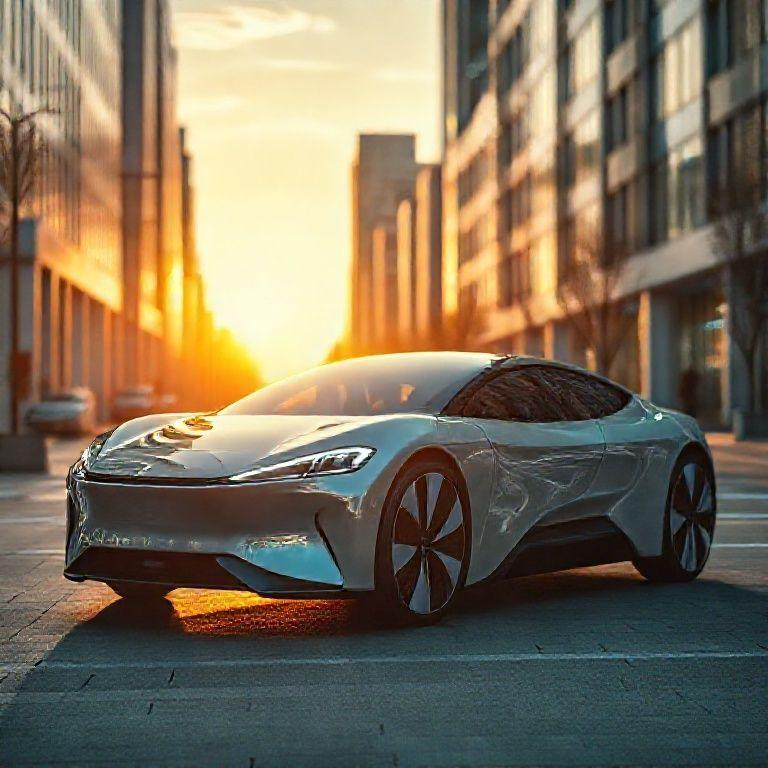



Image 2: Creative/Artistic


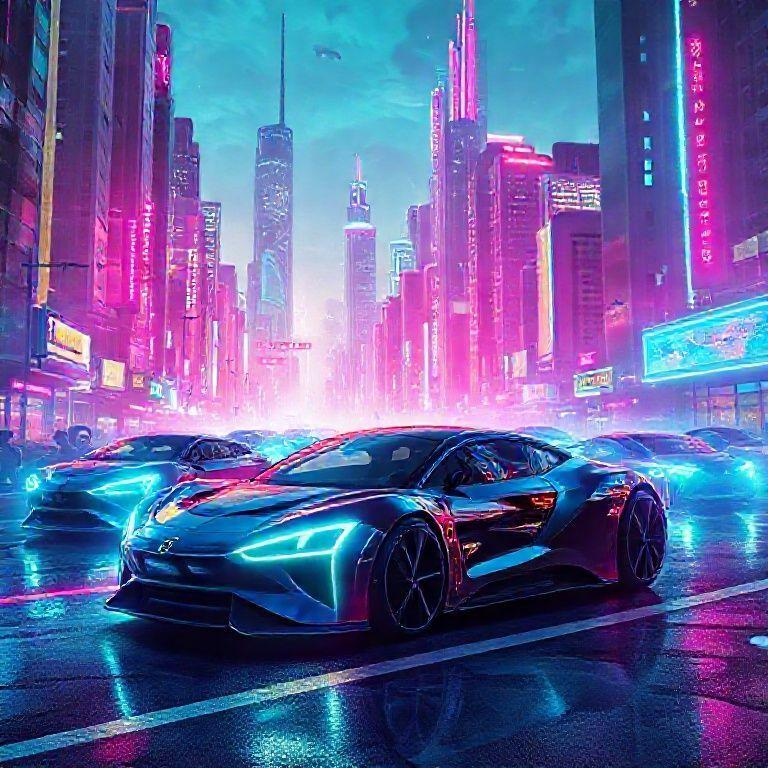



Image 3: Minimalist


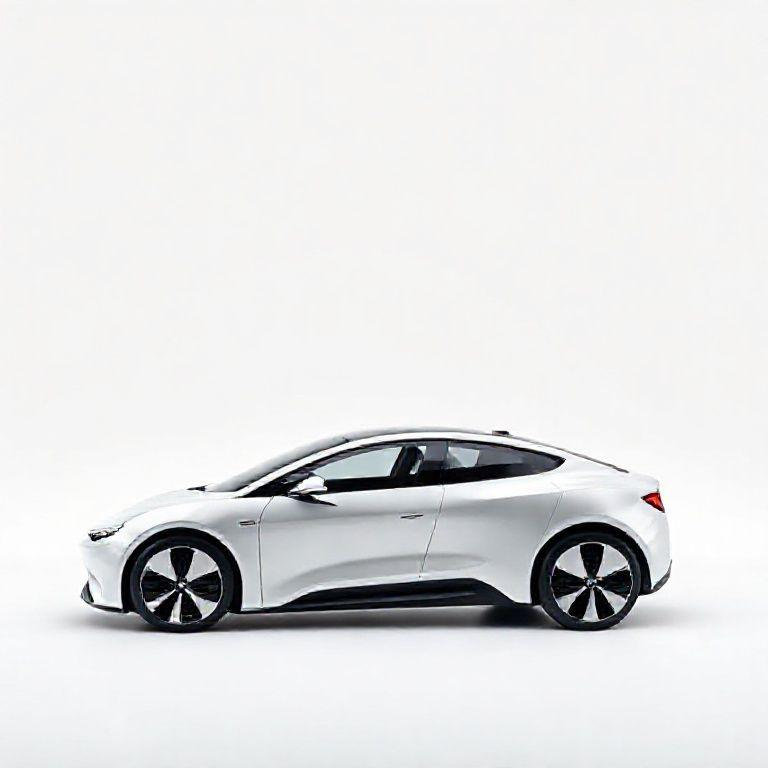



Successfully generated 3/3 images!


In [ ]:
# Generate images
prompts = [
    f"Professional photography of {Topic}, modern urban setting, natural golden hour lighting, sleek electric vehicle, 8k uhd, photorealistic, sharp focus, instagram aesthetic, cinematic",

    f"Creative vibrant digital art of {Topic}, bold neon colors, futuristic cityscape, dynamic composition, trending on artstation, highly detailed, eye-catching, modern design",

    f"Minimalist clean design of {Topic}, white background, simple elegant composition, modern aesthetic, professional photography, centered, instagram ready, high quality"
]

print("\n" + "─"*200)
print("Generating Images (Pollinations AI)")
print("─"*200 + "\n")

images = []
styles = ['Photorealistic', 'Creative/Artistic', 'Minimalist']

for i, prompt in enumerate(prompts, 1):
    filename = f"instagram_image_{i}.jpg"

    print(f"\nImage {i}/3: {styles[i-1]}")
    print(f"Prompt: {prompt[:100]}...")

    status = generate_image(prompt, filename)
    print(f"{status}")

    if os.path. exists(filename):
        images. append(filename)
        print(f"Success")
    else:
        print(f"Failed")

print("\n" + "─"*200)

# Display generated images
if images:
    print("Generated Images:")
    print("─"*200 + "\n")

    for i, img in enumerate(images, 1):
        print(f"\nImage {i}: {styles[i-1]}")
        display(IPImage(filename=img))
        print()

    print(f"\nSuccessfully generated {len(images)}/3 images!")
else:
    print("No images generated.")